In [1]:
!pip install datasets transformers

import pandas as pd
import torch
from transformers import pipeline
from datasets import Dataset
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
# Define the input data and candidate labels
file_path = 'manually_created_tos.csv'
data = pd.read_csv(file_path)
data = data.dropna()

texts = data['text'].tolist()
true_labels = data['label'].tolist()

# Define candidate labels
candidate_labels = ["Risky", "Safe", "Information"]

In [5]:
# Perform zero-shot classification
results = []
for text in texts:
    result = classifier(text, candidate_labels,multi_label=True)
    predicted_label = result["labels"][0]  # Get the highest scoring label
    results.append({
        "text": text,
        "predicted_label": predicted_label,
        "scores": result["scores"]  # Confidence scores for each label
    })

# Create a DataFrame for the results
results_df = pd.DataFrame(results)
print(results_df.head())

# Save the results
results_df.to_csv("classification_results.csv", index=False)

                                                text predicted_label  \
0  We may also share certain information such as ...     Information   
1  Subject to the terms and conditions of this Ag...           Risky   
2  wikiHow may, in its sole discretion, modify or...           Risky   
3  For any dispute with wikiHow, you agree to fir...           Risky   
4  THIS AGREEMENT CONTAINS A MANDATORY ARBITRATIO...           Risky   

                                              scores  
0  [0.8670328259468079, 0.8388484716415405, 0.107...  
1  [0.7976531982421875, 0.5981301069259644, 0.341...  
2  [0.7748186588287354, 0.5749003291130066, 0.230...  
3  [0.9207731485366821, 0.5110243558883667, 0.285...  
4  [0.49779266119003296, 0.24459953606128693, 0.2...  


In [6]:
predicted_labels = [result["predicted_label"] for result in results]

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=candidate_labels)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.2492
Precision: 0.3402
Recall: 0.2492
F1 Score: 0.2342


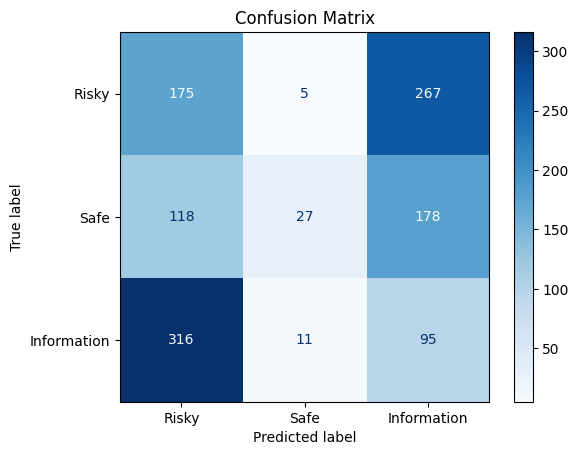

In [7]:
# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=candidate_labels)
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()